In [50]:
import torch
import os
import numpy as np
import re
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
def checkpoint_epoch(folder, epoch=49):
    files = os.listdir(folder)
    f = [f for f in files if "batches_{}_.pth".format(epoch) in f]
    if len(f) > 0:
        return f[0]
    return -1
def add_metadata(fname, d):
    match = re.search('width_mult_\d+', fname)
    if match:
        width_mult = match.group(0)[len("width_mult_"):]
        d["width_mult"] = int(width_mult)
    match = re.search('-lr_\d+.\d+', fname)
    if match:
        value = match.group(0)[len("-lr_"):]
        d["lr"] = float(value)
    match = re.search('-depth_mult_\d+', fname)
    if match:
        value = match.group(0)[len("-depth_mult_"):]
        d["depth_mult"] = int(value)
    match = re.search('-parametr_mup_depth', fname)
    if match:
        d["mup_depth"] = True
    else:
        d["mup_depth"] = False
    match = re.search('skip_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("skip_scaling_"):]
        d["skip_scaling"] = float(value)
    else:
        d["skip_scaling"] = 1.0
    match = re.search('res_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("res_scaling_"):]
        d["res_scaling"] = float(value)
    else:
        d["res_scaling"] = 1.0
    match = re.search('epoch_\d+', fname)
    if match:
        width_mult = match.group(0)[len("epoch_"):]
        d["epochs"] = int(width_mult)
    match = re.search('beta_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("beta_"):]
        d["beta"] = float(value)
    else:
        d["beta"] = 1.0
    match = re.search('gamma_zero_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("gamma_zero_"):]
        d["gamma_zero"] = float(value)
    else:
        d["gamma_zero"] = 1.0
    match = re.search('-norm_ln', fname)
    if match:
        d["norm"] = "ln"
    elif re.search('-norm_bn', fname):
        d["norm"] = "ln"
    elif re.search('-norm_None', fname):
        d["norm"] = None
    else:
        d["norm"] = None
    match = re.search('k_layers_\d+', fname)
    if match:
        value = match.group(0)[len("k_layers_"):]
        d["k_layers"] = int(value)
    else:
        d["k_layers"] = None
    match = re.search('batch_size_\d+', fname)
    if match:
        value = match.group(0)[len("batch_size_"):]
        d["batch_size"] = int(value)
    else:
        d["batch_size"] = None
    return d
def get_data(folder_path, param, epoch=49):
    final_d = []
    for fp in os.listdir(folder_path):
        args_file = json.load(open(os.path.join(folder_path, fp, 'args.json'), 'r'))
        fpath = os.path.join(folder_path, fp)
        d_file = checkpoint_epoch(fpath, epoch=epoch)
        if d_file != -1:
            fpath = os.path.join(fpath, checkpoint_epoch(fpath, epoch=epoch))
            d = torch.load(fpath, map_location=torch.device('cpu'))
            d = add_metadata(fp, d)
            d["name"] = fp
            d['Width'] = args_file['width']
            d['seed'] = args_file['seed']
            final_d.append(d)
    return final_d
def loss_curves(run_ds, train=True, acc=True):
    ds = []
    for d in run_ds:
        loss_d = pd.DataFrame()
        # try:
        if train:
            loss_d["train_loss"] =  d["metrics"]["train_loss"]
            # loss_d["residual"] = d["metrics"]["residual"]
            # loss_d["top_eig_ggn"] = d["metrics"]["top_eig_ggn"]
            if acc:
                if "train_acc" in d["metrics"].keys():
                    loss_d["train_acc"] =  d["metrics"]["train_acc"]
            if "trace" in d["metrics"].keys() and len(d["metrics"]["trace"]) > 1:
                loss_d["trace"] = d["metrics"]["trace"]
            if "top_eig" in d["metrics"].keys() and len(d["metrics"]["top_eig"]) > 1:
                loss_d["top_eig"] = d["metrics"]["top_eig"]
        else:
            loss_d["test_loss"] =  d["metrics"]["test_loss"]
            loss_d["test_acc"] =  d["metrics"]["test_acc"]
        for i in range(100): #some random high number
            ntk_key = f'ntk_eig_{i}'
            if ntk_key in d['metrics'].keys():
                loss_d[ntk_key] = d["metrics"][ntk_key]
            else:
                break
        loss_d["lr"] = d["lr"]
        loss_d["seed"] = d["seed"]
        loss_d["Width"] = d["Width"]# * 3
        loss_d["step"] = loss_d.index
        loss_d["beta"] = d["beta"]
        loss_d["gamma_zero"] = d["gamma_zero"]
        loss_d["k_layers"] = d["k_layers"]
        loss_d["batch_size"] = d["batch_size"]
        ds.append(loss_d)
        # except KeyError:
            # continue
    return pd.concat(ds, axis=0)
def get_metrics_df(run_ds, metric):
    ds = []
    for d in run_ds:
        try:
            d[metric] = d['metrics'][metric][-1]
            d = {k: d[k] for k in (metric, 'lr', 'step', 'width_mult', 'depth_mult', 'mup_depth', 'norm', 'gamma_zero', 'beta', 'k_layers', 'batch_size', 'seed')}
            ds.append(d)
        except KeyError as e:
            print(e)
            continue
    return pd.DataFrame(ds)

In [51]:
sns.set_palette(sns.color_palette("viridis", n_colors=5))
sns.set_theme(style="whitegrid", font_scale=2.0, palette=sns.color_palette("viridis", n_colors=5))
n_epochs = 39
folder_path = "/home/ameterez/work/icml2024/rebuttal/fixed_yang_code_mup_base_256"
metric = "train_loss"
run_ds = get_data(folder_path, param=None, epoch=n_epochs)
df = loss_curves(run_ds, acc=False).reset_index()
# df = df[df['Width'] <= 64]

lrs = sorted(df.lr.unique())
batchsizes = sorted(df.batch_size.unique())
print(batchsizes)
print(lrs)

[None]
[0.000316, 0.000546, 0.000941, 0.001624, 0.002801, 0.004833, 0.008338, 0.014384, 0.024816, 0.042813, 0.073862, 0.127427, 0.219839, 0.379269, 0.654319]


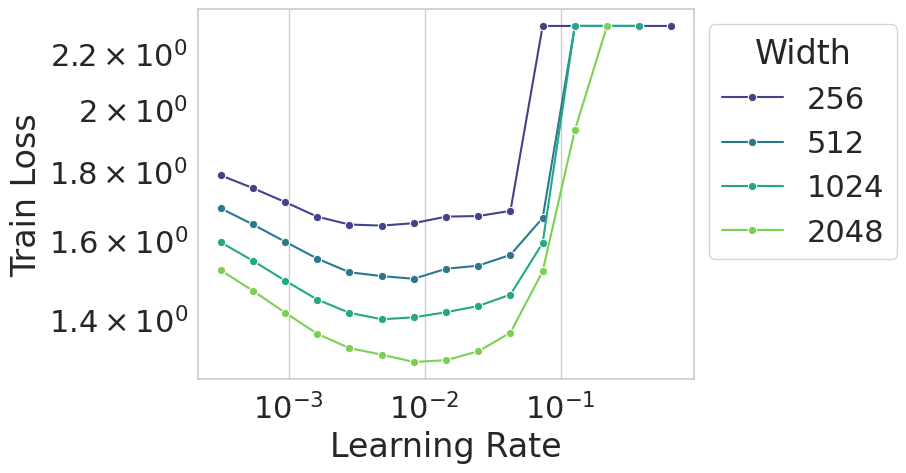

In [53]:
df2 = df[df['step'] == df['step'].max()]
# df2 = df2[df2['lr'] <= 0.1]
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='lr', y='train_loss', hue='Width', ax=ax, marker='o', palette=sns.color_palette("viridis", n_colors=4))
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
# ax.set_ylim(1.3, 1.6)
# ax.set_xlim(5e-3, 0.1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Train Loss")
ax.set_xlabel("Learning Rate")
# ax.set_title(f"Batch size: {batch}")
# fig.savefig(f"rebuttal_model_transfer.pdf", bbox_inches='tight')
fig.show()

/tmp/ipykernel_1291363/1566319398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['top_eig'] /= np.sqrt(df2['Width'])


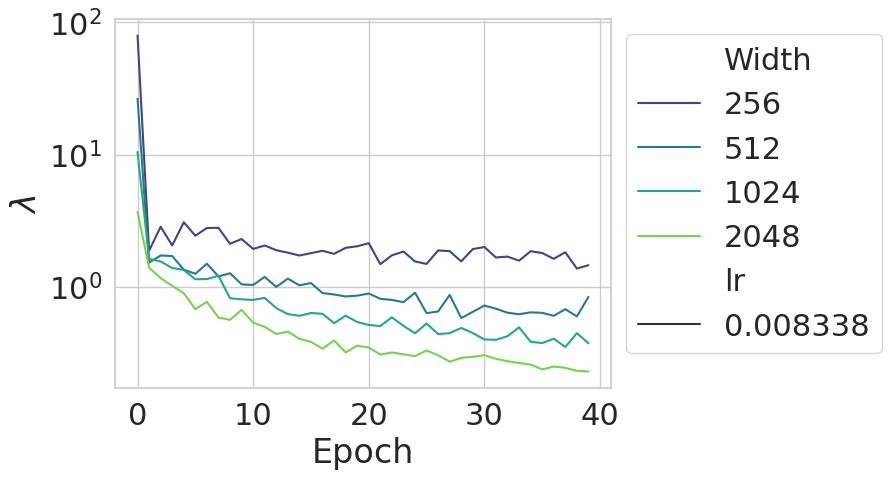

In [59]:
df2 = df[df['lr'].isin([lrs[6]])]
df2['top_eig'] /= np.sqrt(df2['Width'])
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='step', y='top_eig', hue='Width', style='lr', ax=ax, palette=sns.color_palette("viridis", n_colors=4))
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_title(f"Batch size: {batch}")
# fig.savefig(f"ntp_batch_size_{batch}_transfer.pdf", bbox_inches='tight')
ax.set_xlabel("Epoch")
ax.set_ylabel(r"$\lambda$")
# fig.savefig(f"rebuttal_model_sharpness.pdf", bbox_inches='tight')
fig.show()